<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Qiskit_based_electronic_bandstructure_latest_qiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook shows a few examples to use [JARVIS-Tools](https://github.com/usnistgov/jarvis), [AtomQC](https://github.com/usnistgov/atomqc) and [Qiskit](https://qiskit.org/) packages to generate electronic bandstructure for [Aluminum](https://www.ctcms.nist.gov/~knc6/static/JARVIS-DFT/JVASP-816.xml).
#For details see: https://iopscience.iop.org/article/10.1088/1361-648X/ac1154/meta

Note: We are pinning versions of some of the packages as qiskit might have renamed/modified its modules

In [1]:
!pip install -q jarvis-tools qiskit==0.41.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.3 MB/s 

In [2]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
import numpy as np
import itertools, functools
from qiskit.opflow import I, X, Y, Z
from jarvis.db.figshare import get_wann_electron, get_wann_phonon, get_hk_tb
from jarvis.core.circuits import QuantumCircuitLibrary


def decompose_Hamiltonian(H):
    #Inspired from
    # https://github.com/PennyLaneAI/pennylane/blob/master/pennylane/utils.py#L45
    # https://qiskit.org/documentation/tutorials/algorithms/04_vqe_advanced.html
    x, y = H.shape
    N = int(np.log2(len(H)))
    if len(H) - 2 ** N != 0 or x != y:
        raise ValueError(
            "Hamiltonian should be in the form (2^n x 2^n), for any n>=1")
    pauilis = [I, X, Y, Z]
    decomposedH = 0
    for term in itertools.product(pauilis, repeat=N):
        matrices = [i.to_matrix() for i in term]
        # coefficient of the pauli string = (1/2^N) * (Tr[pauliOp x H])
        coeff = np.trace(functools.reduce(np.kron, matrices) @ H) / (2**N)
        coeff = np.real_if_close(coeff).item()
        if coeff == 0:
            continue
        obs = 1
        for i in term:
            obs = obs ^ i
        decomposedH += coeff * obs
    return decomposedH



wtbh, Ef, atoms = get_wann_electron("JVASP-816")
kpt = [0.5, 0., 0.5] # X-point
hk = get_hk_tb(w=wtbh, k=kpt)
wtbh_op=decompose_Hamiltonian(hk)

seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)
n_qubits = int(np.log2(len(hk)))
#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
ansatz = QuantumCircuitLibrary(n_qubits=n_qubits, reps=1).circuit6()
slsqp = SLSQP(maxiter=1000)
vqe = VQE(ansatz, optimizer=slsqp, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=wtbh_op)
np_eig = min(np.linalg.eig(hk)[0])
print ('numpy min. eig', np_eig )

eigenvalue = result.eigenvalue
#print(result)
print('VQE eig.', eigenvalue)

Obtaining raw io files 145k...
Reference:https://www.nature.com/articles/s41524-020-00440-1


100%|██████████| 6.00M/6.00M [00:00<00:00, 7.13MiB/s]


Loading the zipfile...
Loading completed.
H size 15 13 15 8 8
numpy min. eig (4.885195094715013+4.342664158701647e-16j)
VQE eig. (4.885211308472339+0j)


In [3]:
from jarvis.db.figshare import get_wann_electron, get_wann_phonon, get_hk_tb
from jarvis.io.qiskit.inputs import HermitianSolver
from jarvis.core.circuits import QuantumCircuitLibrary
from qiskit import Aer

backend = Aer.get_backend("statevector_simulator")
# Aluminum JARVIS-ID: JVASP-816
wtbh, Ef, atoms = get_wann_electron("JVASP-816")
kpt = [0.5, 0., 0.5] # X-point
hk = get_hk_tb(w=wtbh, k=kpt)
HS = HermitianSolver(hk)
n_qubits = HS.n_qubits()
circ = QuantumCircuitLibrary(n_qubits=n_qubits, reps=1).circuit6()
en, vqe_result, vqe = HS.run_vqe(var_form=circ, backend=backend)
vals,vecs = HS.run_numpy()
# Ef: Fermi-level
print('Classical, VQE (eV):', vals[0]-Ef, en-Ef)
print('Show model\n', circ)

Obtaining raw io files 145k...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.
H size 15 13 15 8 8
Classical, VQE (eV): -3.0437167852849907 (-3.043700571527661+0j)
Show model
      »
q_0: »
     »
q_1: »
     »
q_2: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                             ├
«     │                                                                              │
«q_1: ┤1 EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11]) ├
«     │                                                                              │
«q_2: ┤2                                                                             ├
«     └──────────────────────────────────────────────────────────────────────────────┘


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


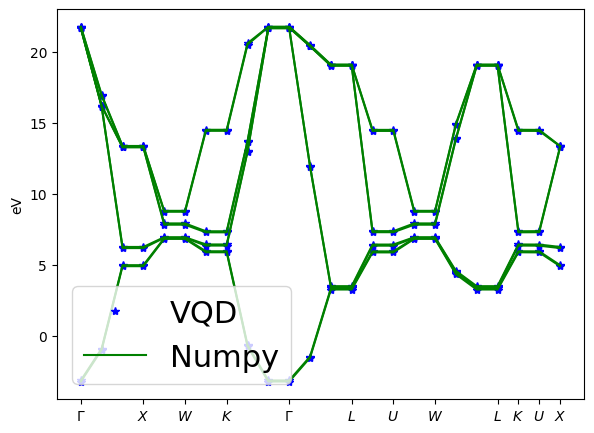

CPU times: user 7min 18s, sys: 7.94 s, total: 7min 26s
Wall time: 7min 32s


In [4]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline
from jarvis.io.qiskit.inputs import get_bandstruct
out=get_bandstruct(w=wtbh,atoms=atoms, line_density=1, savefig=False)
# Scroll down to see th plot

In [5]:
len(out)

6

In [6]:
out.keys()

dict_keys(['eigvals_q', 'eigvals_np', 'kpts', 'new_kp', 'new_labels', 'ef'])

In [7]:
import numpy as np

eigvals_q = (np.array(out['eigvals_q']).real).flatten()
eigvals_np = (np.array(out['eigvals_np']).real).flatten()

In [8]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(eigvals_np,eigvals_q))

0.0029975642955934255


In [ ]:
out['new_kp']

[0, 3, 5, 7, 10, 13, 15, 17, 20, 21, 22, 23]

In [ ]:
out['new_labels']

['$\\Gamma$',
 '$X$',
 '$W$',
 '$K$',
 '$\\Gamma$',
 '$L$',
 '$U$',
 '$W$',
 '$L$',
 '$K$',
 '$U$',
 '$X$']

In [ ]:
out['ef']

0

In [ ]:
out['kpts']

[[0.0, 0.0, 0.0],
 [0.25, 1.7967564939297314e-17, 0.25],
 [0.5, 3.593512987859463e-17, 0.5],
 [0.5, 3.593512987859463e-17, 0.5],
 [0.5, 0.24999999999999997, 0.75],
 [0.5, 0.24999999999999997, 0.75],
 [0.375, 0.37499999999999994, 0.75],
 [0.375, 0.37499999999999994, 0.75],
 [0.1875, 0.18749999999999997, 0.375],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.25, 0.25, 0.25],
 [0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5],
 [0.6250000000000001, 0.25, 0.6250000000000001],
 [0.6250000000000001, 0.25, 0.6250000000000001],
 [0.5, 0.24999999999999997, 0.75],
 [0.5, 0.24999999999999997, 0.75],
 [0.5, 0.375, 0.625],
 [0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5],
 [0.375, 0.37499999999999994, 0.75],
 [0.6250000000000001, 0.25, 0.6250000000000001],
 [0.5, 3.593512987859463e-17, 0.5]]

In [ ]:
eigvals_q


array([-3.24066269, -3.16443735, 21.63721949, 21.64572101, 21.6848682 ,
       21.69508497, 21.73149934, 21.75362106, -0.99044918, -0.91496008,
       16.11340511, 16.1285841 , 16.16823014, 16.18714046, 16.87307868,
       16.95509118,  4.88520351,  4.95714776,  6.16094672,  6.24118643,
       13.2610694 , 13.27919225, 13.32299075, 13.35497151,  4.88520351,
        4.95714776,  6.16094672,  6.24118643, 13.2610694 , 13.27919225,
       13.32299075, 13.35497151,  6.81048262,  6.8546334 ,  6.88072178,
        6.92519056,  7.80902871,  7.89950469,  8.72012799,  8.78517464,
        6.81048262,  6.8546334 ,  6.88072178,  6.92519056,  7.80902871,
        7.89950469,  8.72012799,  8.78517464,  5.86633622,  5.9368361 ,
        6.33828584,  6.41701939,  7.27135868,  7.34574883, 14.4217756 ,
       14.4953806 ,  5.86633622,  5.9368361 ,  6.33828584,  6.41701939,
        7.27135868,  7.34574883, 14.4217756 , 14.4953806 , -0.75363526,
       -0.67758079, 12.94532159, 13.00174039, 13.65328535, 13.68

For benchmark format

In [ ]:
print(';'.join(map(str,eigvals_np)))

-3.2406644491949064;-3.1646320219338793;21.64459303959066;21.666312422834935;21.68275108289057;21.712431803241024;21.73906807176308;21.754949050808428;-0.9904531934312492;-0.9149628220786467;16.112251575114556;16.12899456365257;16.16829144650629;16.187714849081797;16.87352861154704;16.955796969607658;4.885195094715011;4.957138071478262;6.160909829418275;6.241128617395296;13.261350907321047;13.279462731332377;13.336811689973342;13.354988058366393;4.885195094715011;4.957138071478262;6.160909829418275;6.241128617395296;13.261350907321047;13.279462731332377;13.336811689973342;13.354988058366393;6.810201716832547;6.853474935612925;6.881805124460664;6.9253773226592275;7.808934501872465;7.89957293538186;8.720416642895543;8.785191820284778;6.810201716832547;6.853474935612925;6.881805124460664;6.9253773226592275;7.808934501872465;7.89957293538186;8.720416642895543;8.785191820284778;5.866278434041605;5.936743781979645;6.338369423544215;6.417020869933032;7.271346122165133;7.345692500820746;14.421

In [ ]:
print(';'.join(map(str,eigvals_q)))

-3.2406626926799103;-3.1644373508111077;21.637219489939255;21.645721007726287;21.684868201443958;21.695084974338148;21.73149934082567;21.75362105896704;-0.9904491763832318;-0.9149600827493286;16.113405112667987;16.128584098502966;16.168230144549156;16.187140455062107;16.8730786793866;16.955091181204175;4.885203511891229;4.957147757019487;6.16094672241039;6.241186434125918;13.261069395796738;13.279192253504663;13.322990745269694;13.354971510224416;4.885203511891229;4.957147757019487;6.16094672241039;6.241186434125918;13.261069395796738;13.279192253504663;13.322990745269694;13.354971510224416;6.810482616954058;6.85463339750609;6.880721784473817;6.925190561209245;7.80902870952376;7.8995046865450975;8.720127985070787;8.785174635306785;6.810482616954058;6.85463339750609;6.880721784473817;6.925190561209245;7.80902870952376;7.8995046865450975;8.720127985070787;8.785174635306785;5.866336224846163;5.936836104105703;6.33828584093784;6.4170193928668136;7.271358677005512;7.345748829263111;14.42177

In [ ]:
eigvals_q



array([-3.24066269, -3.16443735, 21.63721949, 21.64572101, 21.6848682 ,
       21.69508497, 21.73149934, 21.75362106, -0.99044918, -0.91496008,
       16.11340511, 16.1285841 , 16.16823014, 16.18714046, 16.87307868,
       16.95509118,  4.88520351,  4.95714776,  6.16094672,  6.24118643,
       13.2610694 , 13.27919225, 13.32299075, 13.35497151,  4.88520351,
        4.95714776,  6.16094672,  6.24118643, 13.2610694 , 13.27919225,
       13.32299075, 13.35497151,  6.81048262,  6.8546334 ,  6.88072178,
        6.92519056,  7.80902871,  7.89950469,  8.72012799,  8.78517464,
        6.81048262,  6.8546334 ,  6.88072178,  6.92519056,  7.80902871,
        7.89950469,  8.72012799,  8.78517464,  5.86633622,  5.9368361 ,
        6.33828584,  6.41701939,  7.27135868,  7.34574883, 14.4217756 ,
       14.4953806 ,  5.86633622,  5.9368361 ,  6.33828584,  6.41701939,
        7.27135868,  7.34574883, 14.4217756 , 14.4953806 , -0.75363526,
       -0.67758079, 12.94532159, 13.00174039, 13.65328535, 13.68

In [ ]:
!pip freeze

absl-py==1.4.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.2.0
audioread==3.0.0
autograd==1.5
Babel==2.11.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==6.0.0
blis==0.7.9
bokeh==2.3.3
branca==0.6.0
bs4==0.0.1
CacheControl==0.12.11
cachetools==5.3.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
cftime==1.6.2
chardet==4.0.0
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==2.2.1
cmake==3.22.6
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cryptography==39.0.1
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.3
cycler==0.11.0
cymem==2.0.7
Cython==0.29.33
daft==0.0.4
dask==2022.2.1
datascience==0.17.5
db-dtypes==1.0.5
dbus-python==1.2.16
debugpy==1.0.